<a href="https://colab.research.google.com/github/Ea-mjolnir/Microwave-Remote-sensing/blob/main/Crop_Health_Monitoring_Using_Satellite_Imagery_%26_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: "Crop Health Monitoring Using Satellite Imagery & AI"
# Goal: Analyze satellite images to detect areas of crop stress using vegetation indices and ML.


In [18]:
!pip install rasterio geopandas matplotlib scikit-learn earthengine-api
!pip install geemap
!pip install folium


In [19]:
import ee
import geemap

# Authenticate with your Google Earth Engine account.
ee.Authenticate()

# Initialize Earth Engine with your project ID.
# Replace 'your-project-id' with your actual project ID.
ee.Initialize(project='gee-project-456012')


In [42]:
# Define area of interest (replace with your farmland region, Coimbatore, Tamil Nadu)
aoi = ee.Geometry.Rectangle([77.00, 10.90, 77.30, 11.20])  # Agricultural land near Coimbatore, Tamil Nadu

# Load Sentinel-2 image (less than 5% cloud cover)
image = ee.ImageCollection("COPERNICUS/S2_SR") \
         .filterDate('2025-01-01', '2025-03-30') \
         .filterBounds(aoi) \
         .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5)) \
         .first()

# Select Red (B4), Green (B3), Blue (B2), and NIR (B8) bands
bands = image.select(['B4', 'B3', 'B2', 'B8'])

# Visualize in Colab
import folium
from folium import plugins

def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Display map
vis_params = {'min': 0, 'max': 3000, 'bands': ['B8', 'B4', 'B3']}  # RGB visualization with NIR as Red
m = folium.Map(location=[11.05, 77.15], zoom_start=11)  # Coordinates centered around Coimbatore
m.add_ee_layer(image, vis_params, 'Sentinel-2')
m.add_child(folium.LayerControl())
m


In [45]:
# Define the AOI (Area of Interest) near Coimbatore, Tamil Nadu (1.5 times larger than the original AOI)
aoi = ee.Geometry.Rectangle([77.00, 10.90, 77.30, 11.20])  # Adjusted AOI size

# Load Sentinel-2 image (less than 5% cloud cover)
image = ee.ImageCollection("COPERNICUS/S2_SR") \
         .filterDate('2025-01-01', '2025-03-30') \
         .filterBounds(aoi) \
         .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5)) \
         .first()

# Select Red (B4), Green (B3), Blue (B2), and NIR (B8) bands
bands = image.select(['B4', 'B3', 'B2', 'B8'])

# Define the export task to Google Drive as a GeoTIFF
export_task = ee.batch.Export.image.toDrive(
    image=bands,
    description='SentinelBandsExport',  # Name of the export task
    scale=10,  # Resolution in meters (scale of 10m per pixel)
    region=aoi,  # Define the AOI region
    fileFormat='GeoTIFF'  # GeoTIFF format
)

# Start the export task
export_task.start()

# You can check the status of the export task in the GEE console or in your Google Drive folder


In [46]:
from google.colab import drive
drive.mount('/content/drive')

# Copy exported TIFF from your Drive
!cp "/content/drive/MyDrive/SentinelBandsExport.tif" .


Mounted at /content/drive


<ipython-input-53-f1b55a97a7f0>:15: RuntimeWarning: divide by zero encountered in divide
  evi = G * (nir_band - red_band) / (nir_band + C1 * red_band - C2 * blue_band + L)


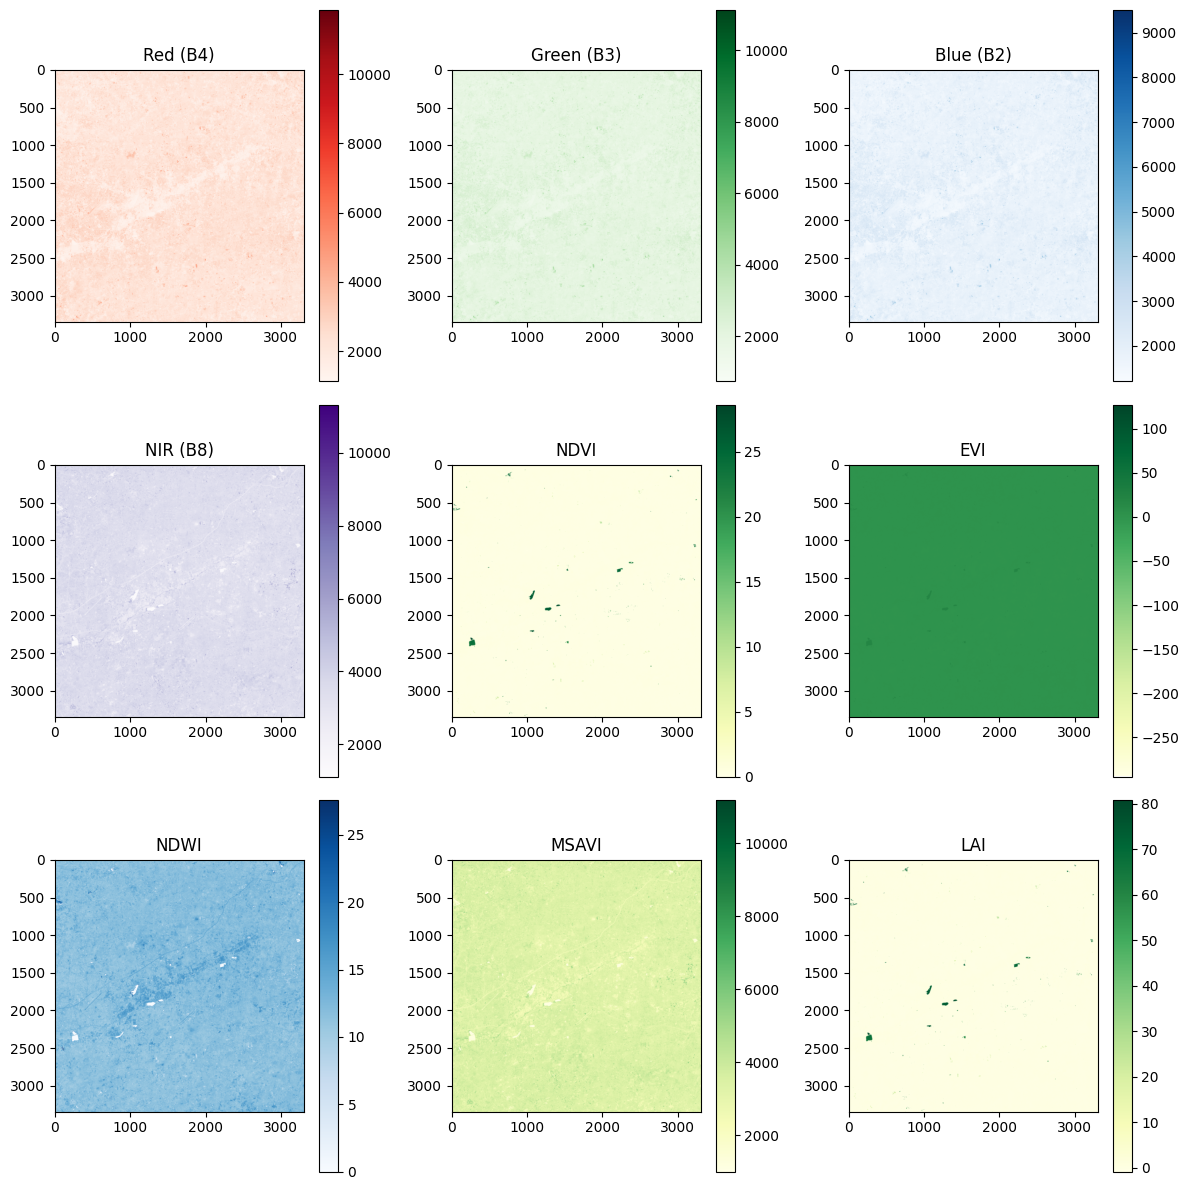

In [53]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the exported GeoTIFF file containing Sentinel-2 bands
with rasterio.open('/content/SentinelBandsExport.tif') as dataset:
    # Read the individual bands (Red, Green, Blue, NIR)
    red_band, green_band, blue_band, nir_band = [dataset.read(i) for i in range(1, 5)]

# Calculate NDVI: (NIR - Red) / (NIR + Red)
ndvi = (nir_band - red_band) / (nir_band + red_band)

# Constants for EVI calculation
G, C1, C2, L = 2.5, 6, 7.5, 10000
evi = G * (nir_band - red_band) / (nir_band + C1 * red_band - C2 * blue_band + L)

# Calculate NDWI: (Green - NIR) / (Green + NIR)
ndwi = (green_band - nir_band) / (green_band + nir_band)

# Calculate MSAVI
msavi = (2 * nir_band + 1 - np.sqrt((2 * nir_band + 1)**2 - 8 * (nir_band - red_band))) / 2

# Calculate LAI: Leaf Area Index (approximation using NDVI)
lai = ((ndvi - 0.3) / 0.7) * 2  # Approximation based on NDVI

# List of bands and indices to display
band_titles = ['Red (B4)', 'Green (B3)', 'Blue (B2)', 'NIR (B8)', 'NDVI', 'EVI', 'NDWI', 'MSAVI', 'LAI']
bands = [red_band, green_band, blue_band, nir_band, ndvi, evi, ndwi, msavi, lai]
cmap_list = ['Reds', 'Greens', 'Blues', 'Purples', 'YlGn', 'YlGn', 'Blues', 'YlGn', 'YlGn']

# Visualizing the bands and indices using matplotlib
plt.figure(figsize=(12, 12))

# Plot each band/vegetation index
for i, (band, title, cmap) in enumerate(zip(bands, band_titles, cmap_list)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(band, cmap=cmap)
    plt.title(title)
    plt.colorbar()

plt.tight_layout()
plt.show()


ML Part of the Code

In [67]:
import rasterio
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.colors import ListedColormap



# === Step 1: Load Bands from GeoTIFF ===
with rasterio.open('/content/SentinelBandsExport.tif') as dataset:
    red = dataset.read(1).astype('float32')   # B4
    green = dataset.read(2).astype('float32') # B3
    blue = dataset.read(3).astype('float32')  # B2
    nir = dataset.read(4).astype('float32')   # B8

# === Step 2: Compute Vegetation Indices ===
def safe_divide(numerator, denominator):
    return np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)

ndvi = safe_divide(nir - red, nir + red)
evi = 2.5 * safe_divide((nir - red), (nir + 6 * red - 7.5 * blue + 1))
savi = 1.5 * safe_divide((nir - red), (nir + red + 0.5))
msavi = 0.5 * (2 * nir + 1 - np.sqrt((2 * nir + 1)**2 - 8 * (nir - red)))
ndwi = safe_divide(green - nir, green + nir)

# === Step 3: Create Multi-Class Labels ===
# 0 = background/no data
# 1 = healthy
# 2 = stressed
# 3 = waterlogged
# 4 = nutrient deficient

labels = np.zeros_like(ndvi, dtype='int')
labels[ndvi > 0.5] = 1  # healthy
labels[(ndvi < 0.2) & (savi < 0.2)] = 2  # stressed
labels[(ndwi > 0.3) & (ndvi < 0.3)] = 3  # waterlogged
labels[(savi < 0.25) & (evi < 0.2)] = 4  # nutrient deficient

# === Step 4: Prepare Features & Labels ===
features = np.stack([ndvi, evi, savi, msavi, ndwi], axis=-1).reshape(-1, 5)
labels_flat = labels.flatten()

# Mask valid pixels
mask = (labels_flat > 0)
features = features[mask]
labels_filtered = labels_flat[mask]

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# One-hot encode labels
labels_onehot = tf.keras.utils.to_categorical(labels_filtered, num_classes=5)

# === Step 5: Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels_onehot, test_size=0.3, random_state=42)



In [68]:
# === Step 6: Build and Train Model ===
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(5,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display training progress
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=512,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9094 - loss: 0.3815 - val_accuracy: 0.9809 - val_loss: 0.0437
Epoch 2/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9804 - loss: 0.0524 - val_accuracy: 0.9899 - val_loss: 0.0248
Epoch 3/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9890 - loss: 0.0299 - val_accuracy: 0.9947 - val_loss: 0.0138
Epoch 4/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9929 - loss: 0.0191 - val_accuracy: 0.9963 - val_loss: 0.0102
Epoch 5/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9945 - loss: 0.0145 - val_accuracy: 0.9974 - val_loss: 0.0078
Epoch 6/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9954 - loss: 0.0120 - val_accuracy: 0.9983 - val_loss: 0.0064
Epoch 7/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9956 - loss: 0.0112 - val_accuracy: 0.9982 - val_loss: 0.0058
Epoch 8/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9961 - loss: 0

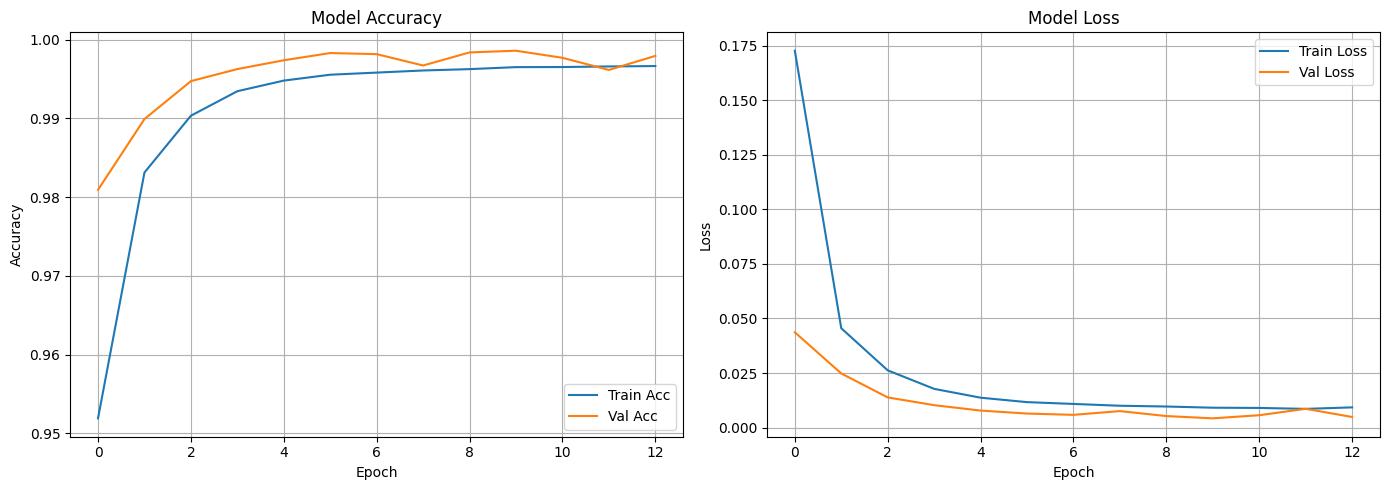

In [69]:
# === Training & Validation Accuracy/Loss Plots ===
plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

15020/15020 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
Classification Report:

                    precision    recall  f1-score   support

           Healthy       1.00      1.00      1.00     18562
          Stressed       1.00      1.00      1.00    409061
Nutrient Deficient       0.99      1.00      0.99     52994

          accuracy                           1.00    480617
         macro avg       1.00      1.00      1.00    480617
      weighted avg       1.00      1.00      1.00    480617



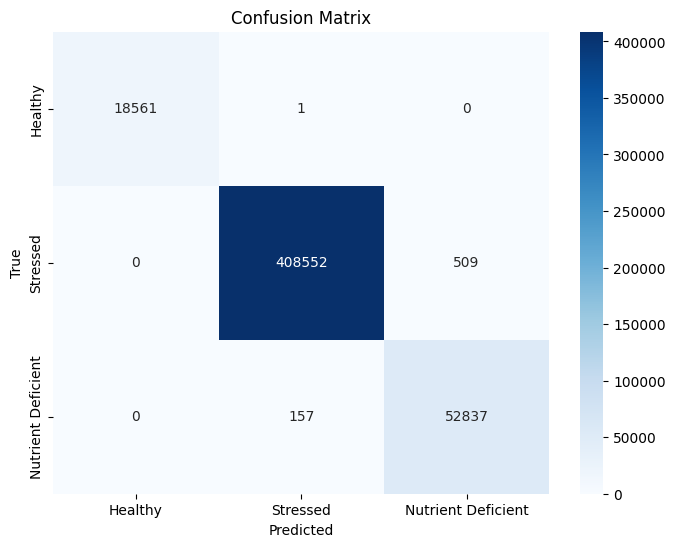

In [70]:
# === Step 7: Evaluate Model ===
y_pred = model.predict(X_test)

# Convert predictions and labels from one-hot to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Get the unique class labels present in the data
unique_labels = np.unique(np.concatenate((y_true_labels, y_pred_labels)))

# Filter target_names to match the unique labels
target_names = [
    "Background", "Healthy", "Stressed", "Waterlogged", "Nutrient Deficient"
]
filtered_target_names = [target_names[i] for i in unique_labels]

# === Classification Report ===
print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels,
                            target_names=filtered_target_names,  # Use filtered target names
                            labels=unique_labels))  # Specify labels


# === Confusion Matrix ===
conf_mat = confusion_matrix(y_true_labels, y_pred_labels, labels=unique_labels) # Specify labels

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=filtered_target_names,  # Use filtered target names
            yticklabels=filtered_target_names)  # Use filtered target names
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

345164/345164 ━━━━━━━━━━━━━━━━━━━━ 505s 1ms/step


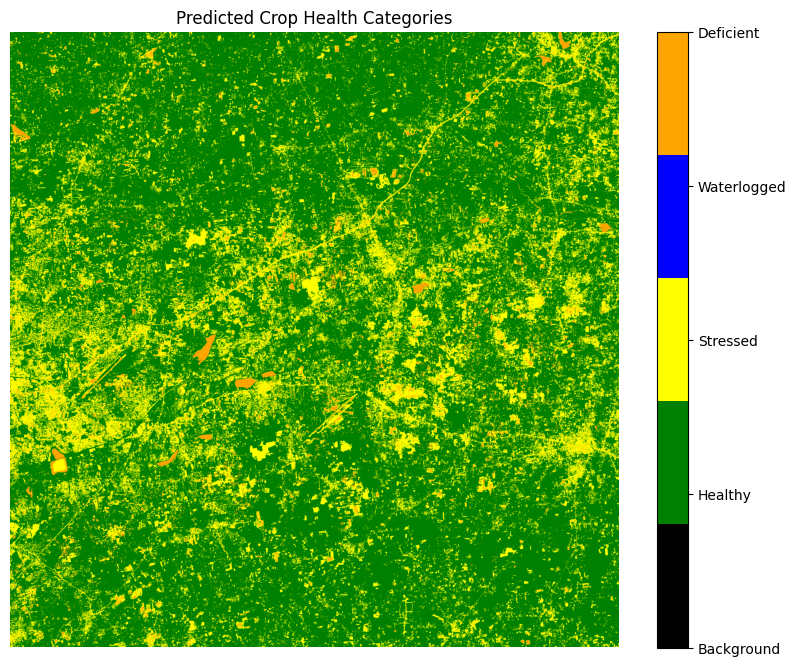

In [71]:
# === Step 8: Predict Entire Image ===
full_pred = model.predict(scaler.transform(np.stack([ndvi, evi, savi, msavi, ndwi], axis=-1).reshape(-1, 5)))
prediction_map = np.argmax(full_pred, axis=1).reshape(ndvi.shape)


# Define custom colors for the 5 classes
colors = ['black', 'green', 'yellow', 'blue', 'orange']  # Match your categories
cmap = ListedColormap(colors)

# Plot with custom colormap
plt.figure(figsize=(10, 8))
plt.imshow(prediction_map, cmap=cmap, vmin=0, vmax=4)
cbar = plt.colorbar(ticks=range(5))
cbar.ax.set_yticklabels(['Background', 'Healthy', 'Stressed', 'Waterlogged', 'Deficient'])
plt.title("Predicted Crop Health Categories")
plt.axis('off')
plt.show()
